In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import itertools
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
from shapely.wkt import loads
# import contextily as ctx
%matplotlib inline

del matplotlib.font_manager.weight_dict['roman']
matplotlib.font_manager._rebuild()
# plt.rcParams[\"font.family\"] = \"Times New Roman\"
font = {'family' : 'Times New Roman', 'weight' : 'normal'}
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', **font)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# matplotlib.rc('text', usetex = True)     ### use latex symbols

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


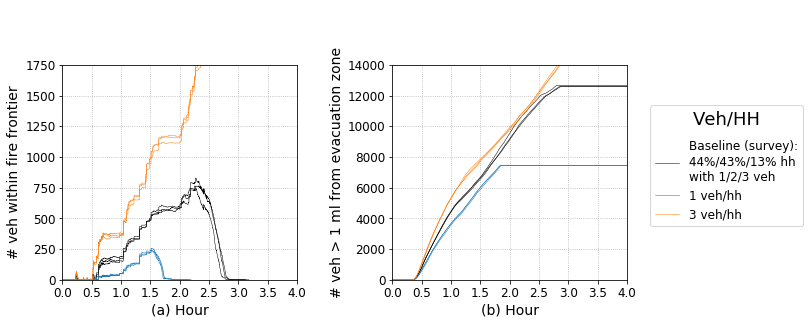

In [5]:
matplotlib.rc('text', usetex = False)
### baseline parameters
b_random_seed=0
b_fire_speed, d_fire_speed = 1, {1: 'Baseline: 1991\nOakland Firestorm', 0.5: r'0.5 $\times$ baseline speed', 2: r'2.0 $\times$ baseline speed'}
b_dept_time_id, d_dept_time_id, d_dept_time_id2 = 'mid', {
    'fst': 'Baseline (fast):\nN(20 min, 10 min)', 
    'mid': 'Medium:\nN(40 min, 20 min)', 
    'slw': 'Slow:\nN(60 min, 30 min)'}, {
    'fst': 'Baseline\ncumulative departure', 
    'mid': 'Medium scenario\ncumulative departure', 
    'slw': 'Slow scenario\ncumulative departure'}
b_tow_pct, d_tow_pct = 0.1, {0: 'Baseline (0%)', 0.1: '10%', 0.25: '25%'}
b_hh_veh, d_hh_veh = 'survey', {'survey': 'Baseline (survey):\n44%/43%/13% hh\nwith 1/2/3 veh', 1: '1 veh/hh', 3: '3 veh/hh'}
b_reroute_pct, d_reroute_pct = 0.15, {0: 'Baseline (0%)', 0.2: '20%', 0.5: '50%', 1: '100%'}
b_phase_tdiff, d_phase_tdiff = 0, {0: 'Baseline (no\nphased evacuation)', 15: '15 min apart', 30: '30 min apart', 60: '60 min apart'}
b_counterflow, d_counterflow = 0, {0: 'Baseline\n(no contraflow)', 1: 'Contraflow'}

### fire speed
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5)
fig.suptitle(' ')
color = iter(['k'] + [plt.rcParams['axes.prop_cycle'].by_key()['color'][0], plt.rcParams['axes.prop_cycle'].by_key()['color'][1], plt.rcParams['axes.prop_cycle'].by_key()['color'][2]])

# for fire_speed in [1, 0.5, 2]:
# for dept_time_id in ['fst', 'mid', 'slw']:
# for tow_pct in [0, 0.1, 0.25]:
for hh_veh in ['survey', 1, 3]:
# for reroute_pct in [0, 0.2, 0.5, 1]:
# for phase_tdiff in [0, 15, 30, 60]:
# for counterflow in [0, 1]:
    c = next(color)
    for random_seed in [0, 5, 10]:
        try:
            file_name = 'projects/berkeley/simulation_outputs/t_stats/t_stats_rs{}_f{}_dt{}_tow{}_hhv{}_r{}_pt{}_cf{}.csv'.format(
                random_seed, b_fire_speed, b_dept_time_id, b_tow_pct, hh_veh, b_reroute_pct, b_phase_tdiff, b_counterflow)
            res = pd.read_csv(file_name)
        except FileNotFoundError:
            print('{} not found'.format(file_name))
            continue
        line,= ax[0].plot(res['t']/3600, res['neg_fdist'], lw=0.5, c=c)
        if random_seed == 5:
            line.set_label(d_hh_veh[hh_veh])
        ax[0].set_ylabel('# veh within fire frontier')
        ax[0].set_xlabel('(a) Hour')
        ax[0].set_xlim([0, 4])
        ax[0].set_ylim([0, 1750])
#         ax[0].set_ylim([0, 3000])
        ax[0].set_xticks(np.arange(0, 4.5, 0.5))
        ax[0].set_yticks(np.arange(0, 1800, 250))
        ax[0].grid(ls=':')

        ax[1].plot((res['t']/3600).values.tolist()+[6], (res['out_evac_buffer_cnts']+res['arr']).values.tolist()+[np.max(res['arr'])], lw=0.5, c=c)
#         line2,= ax[1].plot((res['t']/3600).values.tolist(), (12677-res['init']-res['load']).values.tolist(), lw=0.5, c=c, ls='--', dashes=(5, 10))
#         if random_seed == 5:
#             line2.set_label(d_dept_time_id2[dept_time_id])
#         ax[1].set_ylabel('# veh > 1 ml from evacuation zone\nor # veh started evacuation')
        ax[1].set_ylabel('# veh > 1 ml from evacuation zone')
        ax[1].set_xlabel('(b) Hour')
        ax[1].set_xlim([0, 4])
        ax[1].set_ylim([0, 14000])
#         ax[1].set_ylim([0, 20000])
        ax[1].set_xticks(np.arange(0, 4.5, 0.5))
        ax[1].set_yticks(np.arange(0, 15000, 2000))
        ax[1].grid(ls=':')

handles, labels = ax[0].get_legend_handles_labels()
handles2, labels2 = ax[1].get_legend_handles_labels()
leg = plt.legend(handles+handles2, labels+labels2, loc=[1.1,0.25])
leg.set_title("Veh/HH", prop = {'size': 18})
leg._legend_box.sep = 12
leg._legend_box.align = "center"
plt.show()